# 1. GHZ 4 Qubits sur MonarQ 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from dotenv import dotenv_values
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

from pennylane_snowflurry.API.api_adapter import ApiAdapter
from pennylane_snowflurry.API.api_client import MonarqClient
from pennylane_snowflurry.monarq_device import MonarqDevice

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\__init__.py:200: PennyLaneDeprecationWarning: Device will no longer be accessible top level. Please access the class as pennylane.devices.LegacyDevice
  warn(


In [4]:

# Load environment variables
conf = dotenv_values(".env")
HOST_ENV = conf["HOST"]
USER_ENV = conf["USER"]
ACCESS_TOKEN_ENV = conf["ACCESS_TOKEN"]

num_shots = 1000
num_qubits = 4  # for the simulation

# Real device for measured result
dev_sf = MonarqDevice(
    shots=num_shots,
    host=HOST_ENV,
    user=USER_ENV,
    access_token=ACCESS_TOKEN_ENV
    #realm=REALM_ENV,
)

@qml.qnode(dev_sf)
def ghz():
    qml.Hadamard(wires=4)
    qml.CNOT(wires=[4, 0])
    qml.CNOT(wires=[4, 8])
    qml.CNOT(wires=[4, 1])
    return qml.counts()

@qml.qnode(dev_sf)
def ghz_naive():
    qml.Hadamard(wires=0)
    
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    return qml.counts()

real_result = ghz()
#real_result = ghz_naive()

# 2. Extraire mesures, les arranger et sauvegarder real_data.csv

In [7]:
# SKIP THIS STEP


bitstrings = []
counts = []

for bitstring, count in real_result.items():
    #reordered_bitstring = bitstring[4] + bitstring[0] + bitstring[8] + bitstring[1] #custom à la chip de monarq
    #bitstrings.append(reordered_bitstring)
    bitstrings.append(bitstring[:4]) #si je prends les 4 premiers indices de real_result
    counts.append(count)



# Accumulate counts by unique reordered bitstring
accumulated_data = {}
for bitstring, count in zip(bitstrings, counts):
    if bitstring in accumulated_data:
        accumulated_data[bitstring] += count
    else:
        accumulated_data[bitstring] = count



## SI JE VEUX JUSTE EXTRAIRE LES 4 PREMIERS QUBITS
# for bitstring, count in real_result.items():
#     # Extraire les 4 premiers qubits
#     short_bitstring = bitstring[:4]

#     # Ajouter le compte à la somme des comptes pour ce bitstring
#     if short_bitstring in accumulated_data:
#         accumulated_data[short_bitstring] += int(count.item())
#     else:
#         accumulated_data[short_bitstring] = int(count.item())

# Affichage des résultats
# print("Bitstrings (4 premiers qubits):", list(accumulated_data.keys()))
# print("Counts:", list(accumulated_data.values()))


real_counts = pd.Series(accumulated_data)

# current_date = datetime.now().strftime("%Y%m%d_%H%M")
# folder_name = "GHZ_MonarQ"
# os.makedirs(folder_name, exist_ok=True)

# csv_file = os.path.join(folder_name, f'real_data_{current_date}.csv')

# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["State", "Count"])  # Écrire l'en-tête
#     for bitstring, count in accumulated_data.items():
#         writer.writerow([bitstring, count])



# 3. Simuler default.qubit et sauvegarder simulated_data.csv

In [8]:
# SKIP THIS STEP

# Simulated device for simulated result
dev = qml.device("default.qubit", shots=num_shots)

@qml.qnode(dev)
def ghz_simu():
    qml.Hadamard(wires=0)
    for i in range(1, num_qubits):
        qml.CNOT(wires=[0, i])
    return qml.sample()

simulated_result = ghz_simu()

simulated_result_str = [''.join(map(str, sample[:4])) for sample in simulated_result]  # Keep first 4 qubits
simulated_counts = pd.Series(simulated_result_str).value_counts()



# # Create a DataFrame from the Series
# df = simulated_counts.reset_index()
# df.columns = ['State', 'Count']

# # Save to CSV
# df.to_csv('simulated_data.csv', index=False)




# 4. Plot les résultats

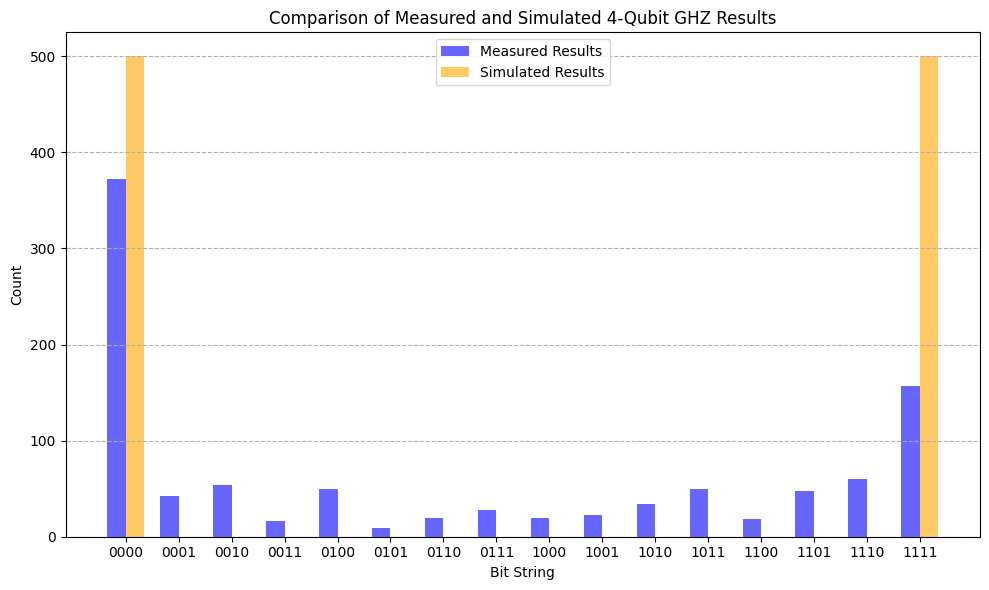

In [9]:
#  Ensure all combinations from '0000' to '1111' are included
all_combinations = [f'{i:04b}' for i in range(2 ** num_qubits)]  # Generate strings from '0000' to '1111'
real_counts_all = real_counts.reindex(all_combinations, fill_value=0)
simulated_counts_all = simulated_counts.reindex(all_combinations, fill_value=0)
# print(real_counts)


# Plot the histograms
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of bars
x = np.arange(len(all_combinations))  

# Create bars for real and simulated results
plt.bar(x - bar_width / 2, real_counts_all, width=bar_width, label='Measured Results', color='blue', alpha=0.6)
plt.bar(x + bar_width / 2, simulated_counts_all, width=bar_width, label='Simulated Results', color='orange', alpha=0.6)

# Add labels and title
plt.title('Comparison of Measured and Simulated 4-Qubit GHZ Results')
plt.xlabel('Bit String')
plt.ylabel('Count')
plt.xticks(x, all_combinations)  
plt.grid(axis='y', linestyle='--')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



# 5. Analyse


2024-11-21 07:09


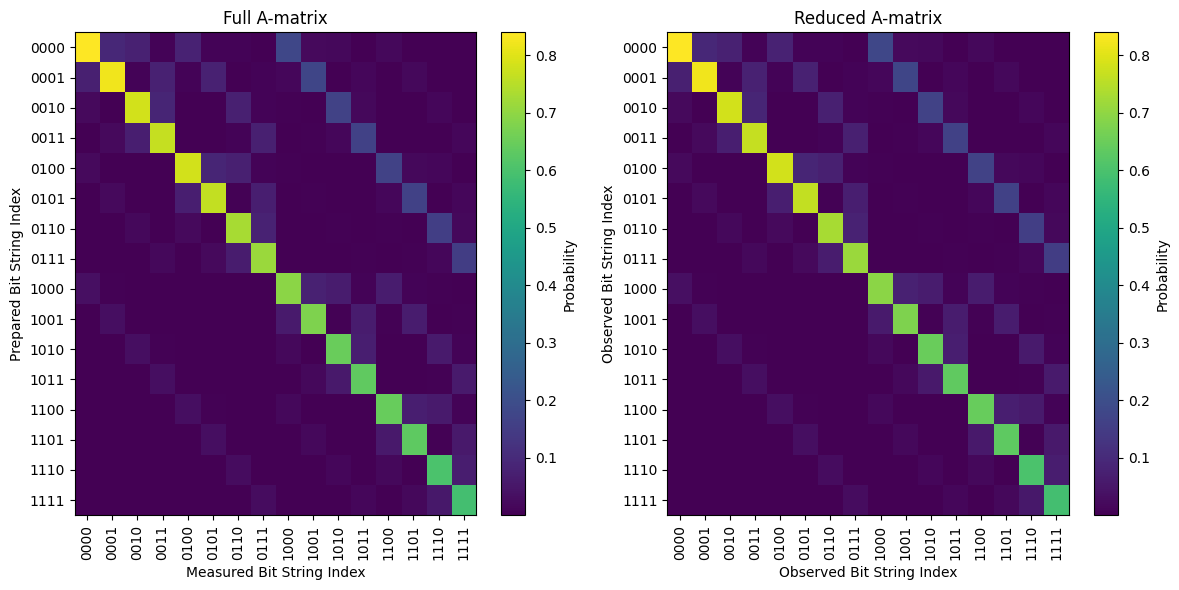

In [ ]:
from numpy.linalg import inv
from pennylane import numpy as np
import pandas as pd
import itertools
import json
from datetime import datetime, timedelta


benchmark = ApiAdapter.get_qubits_and_couplers()
complete_benchmark = json.loads(ApiAdapter.get_benchmark().text)
time_stamp = complete_benchmark["timeStamp"]
time_stamp = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S.%fZ')
time_stamp = time_stamp - timedelta(hours=5)
benchmark_time = time_stamp.strftime('%Y-%m-%d %H:%M')

# Number of qubits
num_qubits = 4
size = 2 ** num_qubits  # Total number of bit strings

myqubits = [4, 0 ,8, 1]
readout0 = {}
readout1 = {}
for i in myqubits:
    readout0[i] = benchmark["qubits"][str(i)]["readoutState0Fidelity"]
    readout1[i] = benchmark["qubits"][str(i)]["readoutState1Fidelity"]    

readout0 = list(readout0.values())
readout1 = list(readout1.values())

print(benchmark_time)

# Je génère des readout fidelities aléatoires 
# state_0_readout_fidelity = np.random.uniform(0.8, 0.94, num_qubits)
# state_1_readout_fidelity = np.random.uniform(0.8, 0.85, num_qubits)

# FROM MONARQ BENCHMARK 
state_0_readout_fidelity = readout0       #np.array([0.977, 0.991, 0.969, 0.985 ]) # 4 0 8 1
state_1_readout_fidelity = readout1       #np.array([0.833, 0.918, 0.850, 0.864])



# Initialize calibration data for each qubit
calibration_data = {
    k: np.array([
        [state_0_readout_fidelity[k], 1 - state_1_readout_fidelity[k]],
        [1 - state_0_readout_fidelity[k], state_1_readout_fidelity[k]]
    ]) for k in range(num_qubits)
}


def tensor_product_calibration(calibration_matrices):
    # Initialize with the first qubit's calibration matrix
    A = calibration_matrices[0]
    
    # Tensor product of calibration matrices for all qubits
    for i in range(1, len(calibration_matrices)):
        A = np.kron(A, calibration_matrices[i])
        
    return A

# Generate the full A-matrix
A_full = tensor_product_calibration(calibration_data)

# normalize it
for col in range(A_full.shape[1]):
    col_sum= np.sum(A_full[:, col])
    if col_sum > 1e-9:  # Threshold to handle potential near-zero sums
        A_full[:, col] /= col_sum



def build_reduced_A_matrix(A_full, observed_bit_strings, all_bit_strings):
    # Convert observed bit strings to their integer indices
    observed_indices = [all_bit_strings.index(bit_str) for bit_str in observed_bit_strings]
    
    # Extract the reduced A-matrix from the full A-matrix
    A_reduced = A_full[np.ix_(observed_indices, observed_indices)]
    
    return A_reduced



observed_bit_string = list(accumulated_data.keys())


#Build the reduced A-matrix
A_reduced = build_reduced_A_matrix(A_full, observed_bit_string, all_combinations)
for col in range(A_reduced.shape[1]):
    col_sum= np.sum(A_reduced[:, col])
    if col_sum > 1e-9:  # Threshold to handle potential near-zero sums
        A_reduced[:, col] /= col_sum
    
#Invert the reduced A-matrix
try:
    A_reduced_inv = np.linalg.inv(A_reduced)
except np.linalg.LinAlgError:
    print("The reduced A-matrix is not invertible, using pseudo-inverse.")
    A_reduced_inv = np.linalg.pinv(A_reduced)

# Step 1: Plot the full A-matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  

# Plotting the full A-matrix as a heatmap
plt.imshow(A_full, cmap='viridis', aspect='auto')
plt.colorbar(label='Probability')
plt.title('Full A-matrix')
plt.xlabel('Measured Bit String Index')
plt.ylabel('Prepared Bit String Index')
plt.xticks(ticks=np.arange(len(all_combinations)), labels=sorted(all_combinations), rotation=90)
plt.yticks(ticks=np.arange(len(all_combinations)), labels=sorted(all_combinations))

# Step 2: Plot the reduced A-matrix
plt.subplot(1, 2, 2)  

# Plotting the reduced A-matrix as a heatmap
plt.imshow(A_reduced, cmap='viridis', aspect='auto')
plt.colorbar(label='Probability')
plt.title('Reduced A-matrix')
plt.xlabel('Observed Bit String Index')
plt.ylabel('Observed Bit String Index')
plt.xticks(ticks=np.arange(len(observed_bit_string)), labels=sorted(observed_bit_string), rotation=90)
plt.yticks(ticks=np.arange(len(observed_bit_string)), labels=sorted(observed_bit_string))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



# 5. Correction

In [11]:
# 5.Correction
corrected_counts = np.dot(A_reduced_inv, real_counts)

corrected_distribution = corrected_counts #/ np.sum(corrected_counts)
noisy_distribution = real_counts #/ np.sum(real_counts)

# mettre la corrected_distribution dans le même format que la noisy
bit_strings = (noisy_distribution.index.tolist())

corrected_distribution = pd.Series(corrected_distribution, index=bit_strings)


sorted_bit_strings = sorted(bit_strings) 
noisy_distribution_sorted = noisy_distribution[sorted_bit_strings]
corrected_distribution_sorted = corrected_distribution[sorted_bit_strings]

noisy_distribution_sorted_all = noisy_distribution_sorted.reindex(all_combinations, fill_value=0)
corrected_distribution_sorted_all = corrected_distribution_sorted.reindex(all_combinations, fill_value=0)





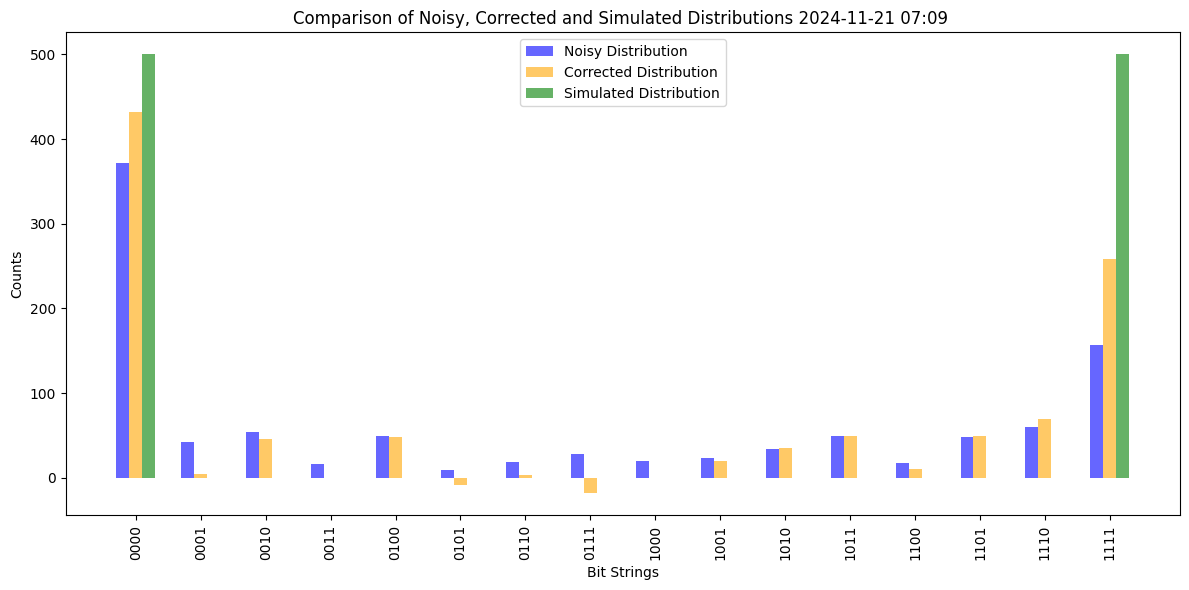

In [12]:
x = np.arange(len(all_combinations))  

plt.figure(figsize=(12, 6))

# Plot noisy distribution
plt.bar(x - 0.2, real_counts_all, width=0.2, label='Noisy Distribution', color='blue', alpha=0.6)

# Plot corrected distribution
plt.bar(x , corrected_distribution_sorted_all, width=0.2, label='Corrected Distribution', color='orange', alpha=0.6)

plt.bar(x + 0.2, simulated_counts_all, width=0.2, label='Simulated Distribution', color='green', alpha=0.6)
#

# Add labels and title
plt.xlabel('Bit Strings')
plt.ylabel('Counts')
plt.title(f'Comparison of Noisy, Corrected and Simulated Distributions {benchmark_time} ')

plt.xticks(ticks=x, labels=all_combinations, rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()